In [1]:
from __future__ import absolute_import, division, print_function

from hippylib import nb
import dolfin as dl
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
%matplotlib inline

import logging
logging.getLogger('FFC').setLevel(logging.ERROR)
logging.getLogger('UFC').setLevel(logging.ERROR)
dl.set_log_active(False)

sys.path.insert(0,'/home/fenics/Installations/MUQ_INSTALL/lib')
from IPython.display import Image

# MUQ Includes
import pymuqModeling as mm # Needed for Gaussian distribution
import pymuqApproximation as ma # Needed for Gaussian processes
import pymuqSamplingAlgorithms as ms # Needed for MCMC

from PAT_forward import PAT_forward

# Hyperparameters

In [2]:
nx = ny = 10
mesh = dl.RectangleMesh(dl.Point(0, 0),dl.Point(1,1),nx,ny,"right")
V = dl.FunctionSpace(mesh, 'P', 1)
time_final = 9.5e-6
numSteps = 14
numObs = 10
c = 1500

# Synthetic Data 

/usr/lib/python3/dist-packages/dolfin/cpp/la.py:1331: DeprecationWarning: GenericVector.array() is being deprecated, use GenericVector.get_local()
  "use GenericVector.get_local()", DeprecationWarning)
/usr/lib/python3/dist-packages/dolfin/cpp/la.py:1331: DeprecationWarning: GenericVector.array() is being deprecated, use GenericVector.get_local()
  "use GenericVector.get_local()", DeprecationWarning)


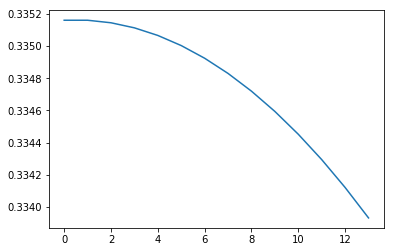

In [3]:
fwdSolver = PAT_forward(time_final, numSteps, c, V, numObs)

# Prior
m = dl.interpolate(dl.Expression('0.5 * exp(-(x[0]-0.5)*(x[0]-0.5)/0.05 -(x[1]-0.5)*(x[1]-0.5)/0.05)', degree=2), V)
#logPriorMu = m.vector().get_local()
#logPriorCov = 0.02*np.eye(V.dim())
#logPrior = mm.Gaussian(logPriorMu, logPriorCov).AsDensity()

# Observation data
obsData = fwdSolver.Evaluate([m.vector().get_local()])[0]

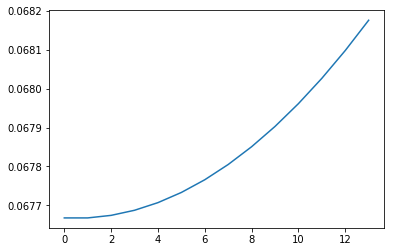

In [12]:
s = 0
plt.plot(obsData[s::numObs])
plt.show()

# Prior

In [ ]:
xDim=2;
yDim=1;

var = 0.7    # Marginal Variance
length = 1 # Lengthscale of the kernel
nu = 1.0/2.0 # Smoothness parameter

kern = ma.MaternKernel(xDim, var, length, nu)

mean = ma.LinearMean(np.zeros((1,xDim)), [0.25])

logPrior = ma.GaussianProcess(mean, kern).Discretize(mesh.coordinates().T).AsDensity()

# Likelihood

In [ ]:
noiseVar = 1e-4
noiseCov = noiseVar*np.eye(obsData.shape[0])
likelihood = mm.Gaussian(obsData, noiseCov).AsDensity()

# Posterior

In [ ]:
posteriorPiece = mm.DensityProduct(2)
p_0 = mm.IdentityOperator(V.dim())

In [ ]:
graph = mm.WorkGraph()

# Forward model nodes and edges
graph.AddNode(p_0, "p_0")
#graph.AddNode(obsOperator, "B")
graph.AddNode(fwdSolver, "u")

graph.AddEdge("p_0", 0, "u", 0)
#graph.AddEdge("u", 0, "B", 0)

# Other nodes and edges
graph.AddNode(likelihood, "Likelihood")
graph.AddNode(logPrior, "Prior")
graph.AddNode(posteriorPiece,"Posterior")

#graph.AddEdge("B", 0, "Likelihood", 0)
graph.AddEdge("u", 0, "Likelihood", 0)
graph.AddEdge("p_0", 0, "Prior", 0)
graph.AddEdge("Prior",0,"Posterior",0)
graph.AddEdge("Likelihood",0, "Posterior",1)

In [ ]:
graph.Visualize("PosteriorGraph.png")
Image(filename='PosteriorGraph.png') 

In [ ]:
problem = ms.SamplingProblem(graph.CreateModPiece("Posterior"))

In [ ]:
'''
proposalOptions = dict()
proposalOptions['Method'] = 'AMProposal'
proposalOptions['ProposalVariance'] = 1e-1
proposalOptions['AdaptSteps'] = 100
proposalOptions['AdaptStart'] = 1000
proposalOptions['AdaptScale'] = 0.1

kernelOptions = dict()
kernelOptions['Method'] = 'MHKernel'
kernelOptions['Proposal'] = 'ProposalBlock'
kernelOptions['ProposalBlock'] = proposalOptions

options = dict()
options['NumSamples'] = 5000
options['ThinIncrement'] = 1
options['BurnIn'] = 1
options['KernelList'] = 'Kernel1'
options['PrintLevel'] = 3
options['Kernel1'] = kernelOptions

mcmc = ms.SingleChainMCMC(options,problem)
'''
# Setup pCN sampler
proposalOptions = dict()
proposalOptions['Method'] = 'CrankNicolsonProposal'
proposalOptions['Beta'] = 0.5
proposalOptions['PriorNode'] = 'Prior' #Needs to know where prior is to extract prior covariances

kernelOptions = dict()
kernelOptions['Method'] = 'MHKernel'
kernelOptions['Proposal'] = 'ProposalBlock'
kernelOptions['ProposalBlock'] = proposalOptions

options = dict()
options['NumSamples'] = 5000
options['ThinIncrement'] = 1
options['BurnIn'] = 10
options['KernelList'] = 'Kernel1'
options['PrintLevel'] = 3
options['Kernel1'] = kernelOptions

mcmc = ms.SingleChainMCMC(options,problem)

In [ ]:
startPt = 0.25*np.ones(V.dim())
samps = mcmc.Run(startPt)

In [ ]:
ess = samps.ESS()
print('Effective Sample Size = \n', ess)

sampMean = samps.Mean()
print('\nSample mean = \n', sampMean)

sampCov = samps.Covariance()
print('\nSample Covariance = \n', sampCov)

mcErr = np.sqrt( samps.Variance() / ess)
print('\nEstimated MC error in mean = \n', mcErr)

nb.plot(m)
plt.title("True p0")
plt.show()

m_post = dl.Function(V)
m_post.vector().set_local(sampMean)
nb.plot(m_post)
plt.title("Posterior mean")
plt.show()

In [ ]:
sampMat = samps.AsMatrix()

In [ ]:
plt.figure(figsize=(15,15))
plt.plot(sampMat.T)
plt.show()

# Plot samples of the posterior predictive

In [ ]:
#predSamps = np.zeros((numPts, sampMat.shape[1]))

#predModel = graph.CreateModPiece("u")

#for i in range(sampMat.shape[1]):
#    predSamps[:,i] = predModel.Evaluate([ sampMat[:,i] ])[0]